The goal of this notebook is to benchmark the bayesian safety validation algorithm to determine where it will break down in higher dimensions.  We start by profiling the algorithm to determine the main bottleneck, then benchmark the main function to compute estimates of the runtime in higher dimensions

Notes on running this notebook:
- [IJulia](https://juliapackages.com/p/ijulia) needs to be installed
- The server should be run from the same directory where IJulia is installed (to ensure that the julia kernel uses the correct environment).  I did this in `scripts/`, but any directory would work
- If the profile plot below isn't interative, try running this notebook in jupyter lab (rather than jupyter notebook)

TLDR: Evaluating the GP on a grid of the input space represents a major bottleneck.  The grid size scales exponentially with the dimensionality of the input space.  Doing this evaluation on an input grid of 10 dimensions, with 50 points along each dimension, would take ~4000 years.

In [1]:
# install necessary packages.  note that IJulia should already be installed (to run this notebook in the first place)
using Pkg
Pkg.add("Revise")
Pkg.add("ProfileVega")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add(path="../")

   Resolving package versions...
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Project.toml`
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Manifest.toml`
   Resolving package versions...
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Project.toml`
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Manifest.toml`
   Resolving package versions...
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Project.toml`
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Manifest.toml`
   Resolving package versions...
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Project.toml`
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Manifest.toml`
    Updating git-repo `/home/rob/code/BayesianSafetyValidation.jl`
   Resolving package versions...
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Project.toml`
  No Changes to `~/code/BayesianSafetyValidation.jl/scripts/Manifest.toml`


In [2]:
using Revise
using BayesianSafetyValidation
using ProfileVega
using Plots
using BenchmarkTools

# Profile a toy problem to see where the bottleneck is 
We use the dummy square system, with a convenience function to create instances in N dimensions

In [3]:
# modified from dummy_squares_system
@with_kw mutable struct DummyParameters <: System.SystemParameters
    failure_point = [[2,2]]
    failure_radius = [2]
end
    
function System.reset(sparams::DummyParameters) end

function System.initialize(sparams::DummyParameters; kwargs...) end

function System.generate_input(sparams::DummyParameters, sample::Vector; kwargs...)
    return sample # pass-through
end

function System.evaluate(sparams::DummyParameters, inputs::Vector; verbose=false, kwargs...)
    verbose && @info "Evaluating dummy system ($inputs)..."
    Y = Vector{Bool}(undef, 0)
    C_vec = sparams.failure_point
    r_vec = sparams.failure_radius
    for input in inputs
        failure = false
        for i in eachindex(C_vec)
            C = C_vec[i]
            r = r_vec[i]
            local_failure = true
            for d in 1:length(C)
                local_failure &= C[d] - r <= input[d] <= C[d] + r
            end
            failure = failure || local_failure
        end
        push!(Y, failure)
    end
    return Y
end

In [4]:
function get_system_and_models(N)
    pt = fill(2, N)
    system_params = DummyParameters(failure_point=[pt], failure_radius=[1])
    models = [OperationalParameters("x_$i", [0, 5], Uniform(0, 5)) for i in 1:N]

    return (system_params, models)
end

get_system_and_models (generic function with 1 method)

In [5]:
system_params, models = get_system_and_models(3)

(DummyParameters
  failure_point: Array{Vector{Int64}}((1,))
  failure_radius: Array{Int64}((1,)) [1]
, OperationalParameters[OperationalParameters("x_1", [0, 5], Uniform{Float64}(a=0.0, b=5.0)), OperationalParameters("x_2", [0, 5], Uniform{Float64}(a=0.0, b=5.0)), OperationalParameters("x_3", [0, 5], Uniform{Float64}(a=0.0, b=5.0))])

In [6]:
# force compilation
gp = bayesian_safety_validation(system_params, models; T=1, input_discretization_steps=10, p_estimate_discretization_steps=10);


----------------------------------------


[ Info: Refinement iteration 1 (acquisition 1)
[ Info: Refinement iteration 1 (acquisition 2)
[ Info: Refinement iteration 1 (acquisition 3)
[ Info: p(fail) estimate = 0.0



----------------------------------------


[ Info: Refinement iteration 1 (acquisition 1)
[ Info: Refinement iteration 1 (acquisition 2)
[ Info: Refinement iteration 1 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 2 (acquisition 1)
[ Info: Refinement iteration 2 (acquisition 2)
[ Info: Refinement iteration 2 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 3 (acquisition 1)
[ Info: Refinement iteration 3 (acquisition 2)
[ Info: Refinement iteration 3 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 4 (acquisition 1)
[ Info: Refinement iteration 4 (acquisition 2)
[ Info: Refinement iteration 4 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 5 (acquisition 1)
[ Info: Refinement iteration 5 (acquisition 2)
[ Info: Refinement iteration 5 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 6 (acquisition 1)
[ Info: Refinement iteration 6 (acquisition 2)
[ Info: Refinement iteration 6 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 7 (acquisition 1)
[ Info: Refinement iteration 7 (acquisition 2)
[ Info: Refinement iteration 7 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 8 (acquisition 1)
[ Info: Refinement iteration 8 (acquisition 2)
[ Info: Refinement iteration 8 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 9 (acquisition 1)
[ Info: Refinement iteration 9 (acquisition 2)
[ Info: Refinement iteration 9 (acquisition 3)



----------------------------------------


[ Info: Refinement iteration 10 (acquisition 1)
[ Info: Refinement iteration 10 (acquisition 2)
[ Info: Refinement iteration 10 (acquisition 3)
[ Info: p(fail) estimate = 0.04339200000000113


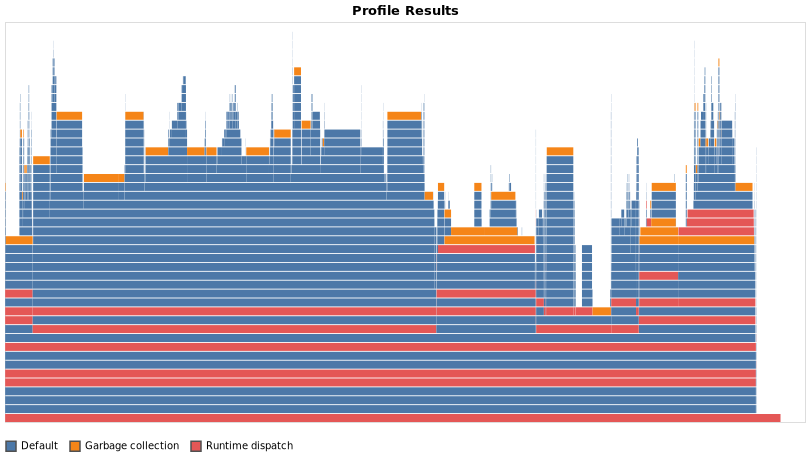

In [7]:
@profview bayesian_safety_validation(system_params, models; T=10, input_discretization_steps=50, p_estimate_discretization_steps=50)

See [here](https://github.com/timholy/ProfileView.jl) for a brief tutorial on interpreting this figure.  Basically, this is a visualization of stack traces collected by julia's profiler.  Each bar represents a function call, with higher bars being at the top of the call stack (i.e. more recently called).  The width of each bar represents how many times it was called.

We see 3 major bottlenecks: lines 79, 82, and 211 of bayesian_safety_validation.jl.  The first and last of these correspond to evaluating the GP on a grid of the input space (first as part of the GP optimization, then again to compute the estimate of failure).  The second bottleneck is computing the pdf of the operational model on the same grid of the input space.  For the remainder of this notebook we will focus on the gp_output function (which performs the GP evaluation on the input space), while noting that the p_output has similar scaling issues.

Assuming a $d$-dimensional input space, with $s$ the number of discritized points per dimension (the `input_discritization_steps` parameter in the code), `gp_output` will need to perform $O(s^d)$ GP evaluzations.  Note that performing a single GP evaluation additionally requires an $O(T^3)$ matrix inversion (where $T$ is the number of iterations of the optimization).  This represents a different scaling concern, and is not further discussed here.

Note that the red lines are possible signs of type-instability, which may be possible to optimize.  I believe these are due to the way `make_broadcastable_grid` works, which creates a vector of n-dimensional arrays, where n is only known at runtime.

# Benchmark the gp_output function
Next we benchmark the gp_output function to get a rough idea of how the performance scales with the size of the input grid.  The below experiments were performed on a laptop with an Intel Core i7-8550U CPU @ 1.80GHz with 4 cores and 32 GB memory.

We use the @belapsed macro (from BenchmarkTools.jl) to run the function multiple times and return the fastest execution time.  We store the execution time and grid size for each test.

In [8]:
n_dim = 3
system_params, models = get_system_and_models(n_dim)
gp = bayesian_safety_validation(system_params, models; T=1, input_discretization_steps=10, p_estimate_discretization_steps=10)

times = []
sizes = []
for steps in [25, 50, 100, 150, 200]
    t = @belapsed gp_output($gp, $models, num_steps=$steps)
    grid_size = steps^n_dim
    push!(sizes, grid_size)
    push!(times, t)
end


----------------------------------------


[ Info: Refinement iteration 1 (acquisition 1)
[ Info: Refinement iteration 1 (acquisition 2)
[ Info: Refinement iteration 1 (acquisition 3)
[ Info: p(fail) estimate = 0.0


In [9]:
times_per_eval_s = times ./ sizes

5-element Vector{Float64}:
 1.180886784e-6
 1.488118728e-6
 1.582911213e-6
 1.4137728577777777e-6
 1.347807421875e-6

In [10]:
time_per_eval_s = mean(times_per_eval_s)

1.4026994009305556e-6

In [11]:
function estimate_time(n_dims, grid_steps)
    n = grid_steps^n_dims
    s = time_per_eval_s * n
    y = s / (60 * 60 * 24 * 365)
    println("Computing gp_output on $n_dims dimensions with $grid_steps grid steps will take $s seconds (or $y years)")
end

estimate_time (generic function with 1 method)

In [12]:
estimate_time(10, 50)

Computing gp_output on 10 dimensions with 50 grid steps will take 1.3698236337212457e11 seconds (or 4343.682247974523 years)
